# Text classification with an RNN

## Setup

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
tfds.disable_progress_bar()

In [2]:
#https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
physical_devices=tf.config.list_physical_devices('GPU')
for device in physical_devices:
   tf.config.experimental.set_memory_growth(device, True)

Grafico para evaluar los accuracy

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

Importamos los datos del CSV

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [4]:
#Leemos el data set desde la estructura dataset de TensorFlow
X_train = list(map(lambda x: x[0].numpy(), train_dataset))
Y_train = list(map(lambda x: x[1].numpy(), train_dataset))

X_test = list(map(lambda x: x[0].numpy(), test_dataset))
Y_test = list(map(lambda x: x[1].numpy(), test_dataset))

#Realizamos un one hot de la variable target
dataTrain = pd.DataFrame({'Review':list(map(lambda x: x.decode('utf-8'), X_train)),'Sentimiento':Y_train}) 
dataTrain = pd.get_dummies(dataTrain, columns=['Sentimiento'])

dataTest = pd.DataFrame({'Review': list(map(lambda x: x.decode('utf-8'), X_test)),'Sentimiento':Y_test})
dataTest = pd.get_dummies(dataTest, columns=['Sentimiento']) 

In [5]:
#volvemos a crear el dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dataTrain['Review'].values, dataTrain[['Sentimiento_0','Sentimiento_1']].values))
test_dataset = tf.data.Dataset.from_tensor_slices((  dataTest['Review'].values,  dataTest[['Sentimiento_0','Sentimiento_1']].values))

Creamos los batch con sus pares correspondientes de (Caracteristicas,target)

In [6]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
#primer Batch sus targets
len(list(train_dataset.as_numpy_iterator())[0][1])

64

## Create the text encoder
Esta capa procesa el texto, es capas de tokenizar el texto y asignar a cada token en numero entero por defecto, ademas calcula cual es el vocabulario.
Con Adapt le decimos que la capa (vocabulario y tokens) se adapten a esos datos.

In [8]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
#De esta forma accedemos al vocabulario , ay que con get_vocabulary da error ya que en ocaciones se almacenaron tokens que no pueden ser decodificados con utf-8
def _get_vocabulary(vectorize_layer):
    keys, values = vectorize_layer._index_lookup_layer._table_handler.data()
    list=[]
    for _, x in sorted(zip(values, keys)):
        try:
            list.append(x.decode('utf-8'))
        except:
            list.append(x)
    return list

#Forma auxliar de Ver el vocabulario
vocab=_get_vocabulary(encoder)

#Forma original
# vocab = np.array(encoder.get_vocabulary())
# vocab[:20]


Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

## Create the model

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(vocab)+1,
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [11]:
# predict on a sample text without padding.

sample_text1 = 'The movie was cool. The animation and the graphics'
sample_text2 = 'The movie was terrible. so bad'
a= np.array([sample_text1,sample_text2])
predictions = model.predict(a)
print(predictions)

[[0.5011362  0.49886382]
 [0.5030087  0.49699125]]


Compile the Keras model to configure the training process:

In [12]:
#Con from logist asumimos que se trata de una distribucion de probabilidad
#https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          7793792   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 7,868,226
Trainable params: 7,868,226
Non-trainable params: 0
_________________________________________________________________
None


## Train the model

In [13]:
history = model.fit(train_dataset, epochs=5,validation_data=test_dataset,validation_steps=30)

Epoch 1/5
391/391 [==============================] - 106s 246ms/step - loss: 0.6125 - accuracy: 0.6564 - val_loss: 0.4310 - val_accuracy: 0.8286
Epoch 2/5
391/391 [==============================] - 92s 236ms/step - loss: 0.2801 - accuracy: 0.8927 - val_loss: 0.3565 - val_accuracy: 0.8672
Epoch 3/5
391/391 [==============================] - 94s 240ms/step - loss: 0.1530 - accuracy: 0.9465 - val_loss: 0.3448 - val_accuracy: 0.8807
Epoch 4/5
391/391 [==============================] - 93s 238ms/step - loss: 0.0882 - accuracy: 0.9734 - val_loss: 0.3395 - val_accuracy: 0.8729
Epoch 5/5
391/391 [==============================] - 78s 199ms/step - loss: 0.0488 - accuracy: 0.9874 - val_loss: 0.4162 - val_accuracy: 0.8698


In [14]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.4141 - accuracy: 0.8658
Test Loss: 0.41406798362731934
Test Accuracy: 0.8658000230789185


(0.0, 0.6406636176630854)

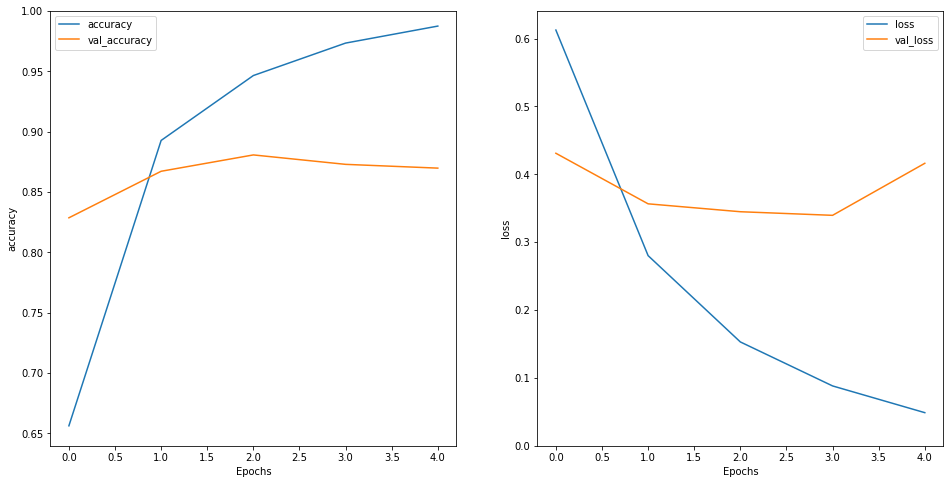

In [15]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [19]:
sample_text = ('were out of this world. I wouldnt recommend this good movi')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.3178072, 0.6821928]], dtype=float32)

# Forma de Guardar 1

In [ ]:
#https://www.tensorflow.org/guide/keras/save_and_serialize?hl=es-419
# Guardar el Modelo
model.save('modulo3',save_format="tf")

In [3]:
# Recrea exactamente el mismo modelo solo desde la carpera formato tf
new_model = tf.keras.models.load_model('modulo3',compile=True)

sample_text = ('were out of this world. I wouldnt recommend this good movi')
new_model.predict(np.array([sample_text]))

array([[0.3178072, 0.6821928]], dtype=float32)

In [16]:
 new_model.get_weights()[9].shape

(128, 64)

# Forma de Guarda 2

In [10]:
# Guardar configuración JSON en el disco
json_config = new_model.to_json()
with open('modelo/model_config.json', 'w') as json_file:
    json_file.write(json_config)
# Guardar pesos en el disco
new_model.save_weights('modelo/path_to_my_weights',save_format="tf")

In [9]:
# Recargue el modelo de los 2 archivos que guardamos
with open('modelo/model_config.json') as json_file:
    json_config = json_file.read()
new_model = tf.keras.models.model_from_json(json_config)
new_model.load_weights('modelo/path_to_my_weights')

sample_text = ('were out of this world. I would recommend this good movi')
new_model.predict(np.array([sample_text]))

array([[0.2858246, 0.7141754]], dtype=float32)